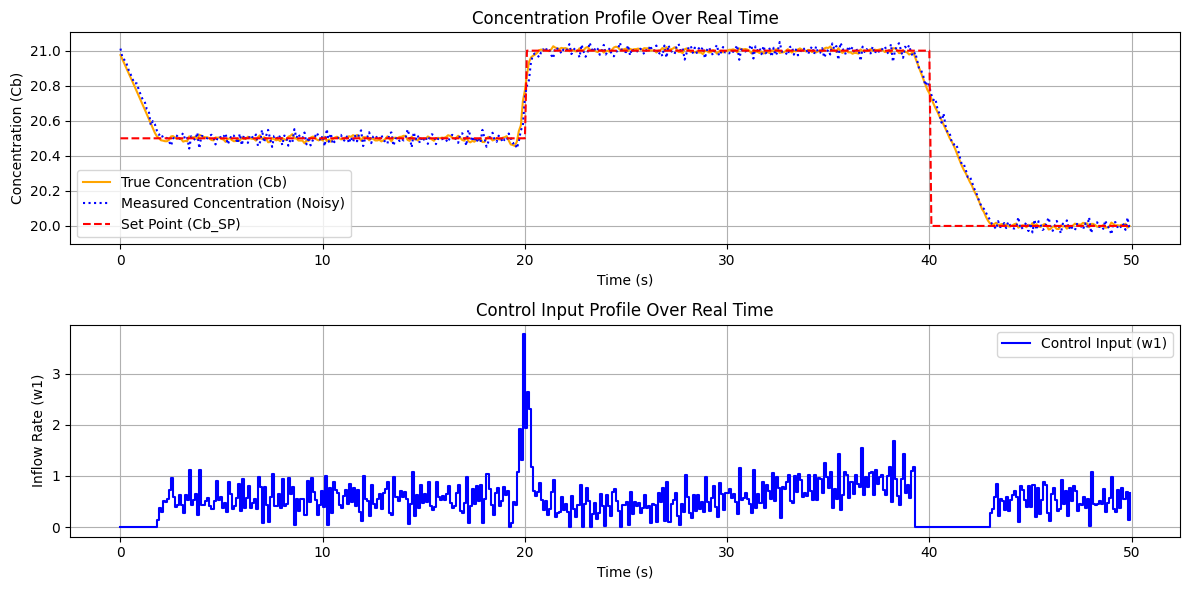

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Discretization time step
dt = 0.1

# Parameters
Cb1 = 24.9
Cb2 = 0.1
k1 = 1.0
k2 = 1.0
h0 = 10.0  # Initial height
Cb0 = 21.0  # Initial concentration

# Cost function weights
Q_Cb = 10.0  # Weight for concentration tracking
R = 0.1  # Weight for control effort

# Prediction horizon and control horizon
N_p = 10
N_u = 5

# Constraints
w1_min, w1_max = 0.0, 4.0


# Discrete-time system dynamics
def system_dynamics(h, Cb, w1, w2):
    h_next = h + dt * (w1 + w2 - 0.2 * np.sqrt(h))
    Cb_next = Cb + dt * (
            (Cb1 - Cb) * w1 / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb) ** 2
    )
    return h_next, Cb_next


# Dynamic set point for concentration
def Cb_set_point(t):
    if t <= 20:
        return 20.5
    elif t <= 40:
        return 21.0
    elif t <= 60:
        return 20.0
    else:
        return 21.5


# Cost function for MPC
def cost_function(w1_seq, h0, Cb0, t0):
    h = h0
    Cb = Cb0
    J = 0.0
    for k in range(N_p):
        w1 = w1_seq[min(k, N_u - 1)]
        t = t0 + k * dt
        Cb_SP = Cb_set_point(t)
        h, Cb = system_dynamics(h, Cb, w1, w2)
        J += Q_Cb * (Cb - Cb_SP) ** 2  # Penalize concentration tracking error
        if k > 0:
            J += R * (w1 - w1_seq[k - 1]) ** 2  # Penalize control effort changes
    return J


# Introduce realistic disturbances
def disturbance_w2(t):
    # Vary w2 with different scenarios
    if t < 20:
        return 0.1  # Constant disturbance
    elif t < 40:
        return 0.1 + 0.05 * np.sin(0.2 * t)  # Sinusoidal disturbance
    else:
        return 0.1 + np.random.normal(0, 0.02)  # Stochastic disturbance


# Simulate the system with MPC
time_steps = 500
h = h0
Cb = Cb0
h_history = []
Cb_history = []
w1_history = []
measured_Cb_history = []

for t in range(time_steps):
    # Introduce noise to the measured output
    measured_Cb = Cb + np.random.normal(0, 0.02)  # Add Gaussian noise to the concentration measurement
    measured_Cb_history.append(measured_Cb)

    # Optimize control input sequence
    w2 = disturbance_w2(t * dt)
    w1_init = np.ones(N_p) * 2.0  # Initial guess for w1
    result = minimize(
        cost_function,
        w1_init,
        args=(h, measured_Cb, t * dt),  # Use noisy measurement
        bounds=[(w1_min, w1_max)] * N_p,
    )
    w1_opt = result.x if result.success else np.ones(N_p) * 2.0

    # Apply the first control input
    w1 = w1_opt[0]
    w1_history.append(w1)

    # Update the system state
    h, Cb = system_dynamics(h, Cb, w1, w2)
    h_history.append(h)
    Cb_history.append(Cb)

# Create the absolute time array
time = np.arange(0, time_steps * dt, dt)  # Real time based on dt

# Plot concentration (Cb) against real time
plt.figure(figsize=(12, 6))

# Plot the actual concentration (Cb) over real time
plt.subplot(2, 1, 1)
plt.plot(time, Cb_history, label="True Concentration (Cb)", color="orange")
plt.plot(time, measured_Cb_history, label="Measured Concentration (Noisy)", linestyle="dotted", color="blue")
plt.plot(time, [Cb_set_point(t) for t in time], 'r--', label="Set Point (Cb_SP)")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (Cb)")
plt.title("Concentration Profile Over Real Time")
plt.legend()
plt.grid()

# Plot control input (w1) over real time
plt.subplot(2, 1, 2)
plt.step(time, w1_history, where='post', label="Control Input (w1)", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Inflow Rate (w1)")
plt.title("Control Input Profile Over Real Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

